<a href="https://colab.research.google.com/github/sbooeshaghi/azucar/blob/main/analysis/brain/biologics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install --quiet leidenalg louvain anndata umap-learn pynndescent session-info
!pip install --quiet --no-deps scanpy

     |████████████████████████████████| 1.3 MB 5.3 MB/s 
     |████████████████████████████████| 1.1 MB 41.4 MB/s 
     |████████████████████████████████| 96 kB 5.5 MB/s 
     |████████████████████████████████| 88 kB 6.9 MB/s 
     |████████████████████████████████| 1.1 MB 61.0 MB/s 
     |████████████████████████████████| 3.2 MB 38.7 MB/s 
     |████████████████████████████████| 63 kB 1.7 MB/s 
     |████████████████████████████████| 2.0 MB 5.3 MB/s 


In [2]:
!curl -Ls https://github.com/sbooeshaghi/azucar/blob/main/data/brain/rep1/rep.h5ad.gz?raw=true | gunzip > rep1.h5ad
!cat <(curl -Ls https://github.com/sbooeshaghi/azucar/blob/main/data/brain/rep2/rep.h5ad.gz.1?raw=true) \
     <(curl -Ls https://github.com/sbooeshaghi/azucar/blob/main/data/brain/rep2/rep.h5ad.gz.2?raw=true) | gunzip > rep2.h5ad

In [8]:
!curl -Ls https://github.com/sbooeshaghi/azucar/blob/main/reference/brain/celltype/markers.txt?raw=true > markers.txt

In [27]:
import anndata
import scanpy as sc
import pandas as pd
from collections import defaultdict
import numpy as np
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize, scale
import glob
from sklearn.mixture import GaussianMixture
import numpy.lib.recfunctions as rf

def nd(arr):
    return np.asarray(arr).reshape(-1)

fsize=20

plt.rcParams.update({'font.size': fsize})
%config InlineBackend.figure_format = 'retina'

In [53]:
markers = defaultdict(list)
with open("markers.txt", "r") as f:
    for idx, line in enumerate(f.readlines()):
        ct_id, gene_ids = line.strip().split("\t")
        markers[ct_id] = [i for i in gene_ids.split(",")]

In [63]:
df = pd.concat([pd.Series(v, name=k).astype(str) for k, v in markers.items()], 
               axis=1)
df = pd.get_dummies(df.stack()).sum(level=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  This is separate from the ipykernel package so we can avoid doing imports until


In [4]:
r1 = anndata.read_h5ad("rep1.h5ad")
r1.layers["raw"] = r1.X
r1.var.index = r1.var["gene_name"].astype(str) + "_" + r1.var.index.astype(str)

r2 = anndata.read_h5ad("rep2.h5ad")
r2.layers["raw"] = r2.X
r2.var.index = r2.var["gene_name"].astype(str) + "_" + r2.var.index.astype(str)

In [5]:
print(f"Replicate 1: {r1.shape}")
print(f"Replicate 2: {r2.shape}")

Replicate 1: (13221, 55416)
Replicate 2: (50394, 55416)


# Standard QC

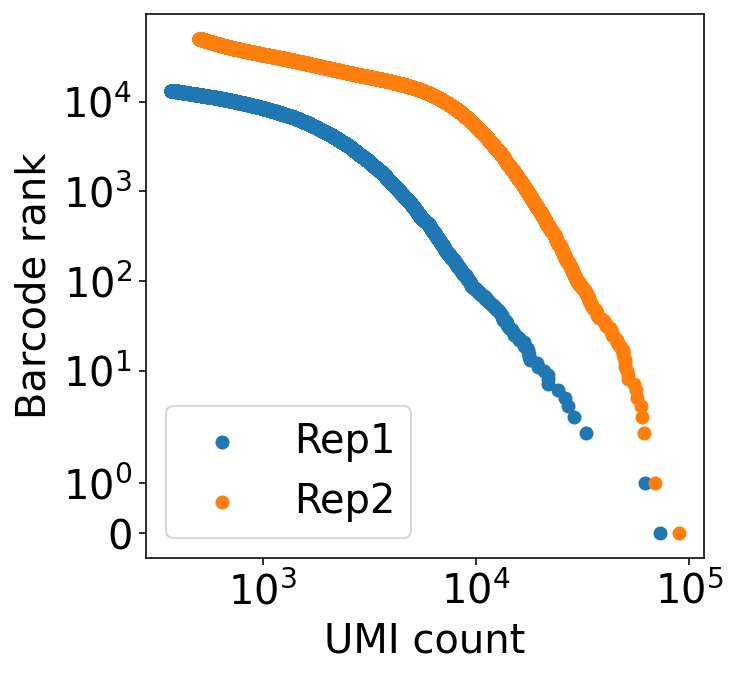

In [6]:
fig, ax = plt.subplots(figsize=(5,5))

data = r1
label = "Rep1"
x = np.sort(nd(data.X.sum(1)))[::-1]
y = np.arange(data.shape[0])

ax.scatter(x,y, label=label)

data = r2
label = "Rep2"
x = np.sort(nd(data.X.sum(1)))[::-1]
y = np.arange(data.shape[0])

ax.scatter(x,y, label=label)

ax.set(**{
    "xlabel": "UMI count",
    "ylabel": "Barcode rank",
    "xscale": "symlog",
    "yscale": "symlog"
})

ax.legend()

fig.show()

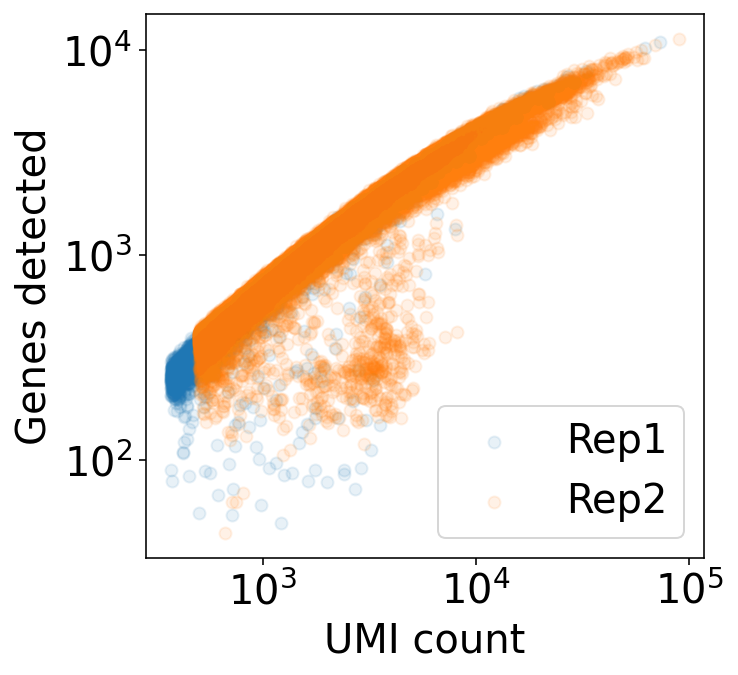

In [7]:
fig, ax = plt.subplots(figsize=(5,5))

data = r1
label = "Rep1"
x = nd(data.X.sum(1))
y = nd((data.X>0).sum(1))

ax.scatter(x,y, label=label, alpha=0.1)

data = r2
label = "Rep2"
x = nd(data.X.sum(1))
y = nd((data.X>0).sum(1))

ax.scatter(x,y, label=label, alpha=0.1)

ax.set(**{
    "xlabel": "UMI count",
    "ylabel": "Genes detected",
    "xscale": "symlog",
    "yscale": "symlog"
})

ax.legend()

fig.show()

# Normalization

In [10]:
# replicate 1
r1.layers["PF"] = normalize(r1.layers["raw"], norm="l1")*r1.layers["raw"].sum(1).mean()
r1.layers["log1pPF"] = np.log1p(r1.layers["PF"])
r1.layers["PFlog1pPF"] = normalize(r1.layers["log1pPF"], norm="l1")*r1.layers["log1pPF"].sum(1).mean()


# replicate 2
r2.layers["PF"] = normalize(r2.layers["raw"], norm="l1")*r2.layers["raw"].sum(1).mean()
r2.layers["log1pPF"] = np.log1p(r2.layers["PF"])
r2.layers["PFlog1pPF"] = normalize(r2.layers["log1pPF"], norm="l1")*r2.layers["log1pPF"].sum(1).mean()



In [66]:
mgenes = df.columns.values

In [74]:
r1.var_names = r1.var["gene_name"].astype(str)
r2.var_names = r2.var["gene_name"].astype(str)

In [75]:
r1m = r1[:,r1.var["gene_name"].isin(mgenes)][:,mgenes].copy()
r2m = r2[:,r2.var["gene_name"].isin(mgenes)][:,mgenes].copy()

In [77]:
# replicate 1
r1m.layers["PFm"] = normalize(r1m.layers["raw"], norm="l1")*r1m.layers["raw"].sum(1).mean()
r1m.layers["log1pPFm"] = np.log1p(r1m.layers["PFm"])
r1m.layers["PFlog1pPFm"] = normalize(r1m.layers["log1pPFm"], norm="l1")*r1m.layers["log1pPFm"].sum(1).mean()


# replicate 2
r2m.layers["PFm"] = normalize(r2m.layers["raw"], norm="l1")*r2m.layers["raw"].sum(1).mean()
r2m.layers["log1pPFm"] = np.log1p(r2m.layers["PFm"])
r2m.layers["PFlog1pPFm"] = normalize(r2m.layers["log1pPFm"], norm="l1")*r2m.layers["log1pPFm"].sum(1).mean()

In [25]:
# r1.X = r1.layers["PFlog1pPF"].copy()
# r2.X = r2.layers["PFlog1pPF"].copy()
# sc.pp.highly_variable_genes(r1, layer="log1pPF")
# sc.pp.highly_variable_genes(r2, layer="log1pPF")
# # We perform PCA on just the highly variable genes
# sc.tl.pca(r1, svd_solver='arpack', n_comps=100, use_highly_variable=True)

# sc.pp.neighbors(r1, n_neighbors=50, use_rep="X_pca")

# sc.tl.leiden(r1, random_state=42)

# print(r1.obs["leiden"].nunique())
# print(r1.obs["leiden"].value_counts())

# # We perform PCA on just the highly variable genes
# sc.tl.pca(r2, svd_solver='arpack', n_comps=100, use_highly_variable=True)

# sc.pp.neighbors(r2, n_neighbors=50, use_rep="X_pca")

# sc.tl.leiden(r2, random_state=42)

# print(r2.obs["leiden"].nunique())
# print(r2.obs["leiden"].value_counts())

# sc.tl.rank_genes_groups(r1, 'leiden', method='t-test', corr_method="bonferroni", layer="PFlog1pPF")
# sc.tl.rank_genes_groups(r2, 'leiden', method='t-test', corr_method="bonferroni", layer="PFlog1pPF")

# # replicate 1
# pvals = rf.structured_to_unstructured(r1.uns["rank_genes_groups"]["pvals_adj"]).ravel()
# scores = rf.structured_to_unstructured(r1.uns["rank_genes_groups"]["scores"]).ravel()
# names = np.array([np.asarray(tuple(i)) for i in r1.uns["rank_genes_groups"]["names"]]).ravel()
# leiden = np.tile(np.arange(0, r1.obs.leiden.nunique()), r1.shape[1]).reshape(-1, r1.obs.leiden.nunique()).ravel()

# df1 = pd.DataFrame({"pvals": pvals, "scores": scores, "names": names, "leiden": leiden})

# # replicate 1
# pvals = rf.structured_to_unstructured(r2.uns["rank_genes_groups"]["pvals_adj"]).ravel()
# scores = rf.structured_to_unstructured(r2.uns["rank_genes_groups"]["scores"]).ravel()
# names = np.array([np.asarray(tuple(i)) for i in r2.uns["rank_genes_groups"]["names"]]).ravel()
# leiden = np.tile(np.arange(0, r2.obs.leiden.nunique()), r2.shape[1]).reshape(-1, r2.obs.leiden.nunique()).ravel()

# df2 = pd.DataFrame({"pvals": pvals, "scores": scores, "names": names, "leiden": leiden})

# df1.query("pvals < 1e-5 & scores > 10").groupby("leiden")["names"].apply(list)

In [78]:
gmm = GaussianMixture(n_components=len(markers.keys()), random_state=12)
mtx = r1m.layers["PFlog1pPFm"].A
labels = gmm.fit_predict(mtx)

In [79]:
means = pd.DataFrame(mtx, columns=r1m.var["gene_name"], index=pd.Index(labels, name="labels")).groupby("labels").mean()

In [80]:
means

gene_name,Aldoc,Apoe,Aqp1,Bhlhe22,C1ql1,Calb2,Ccna2,Cldn5,Cxcl14,Dcn,...,Riiad1,Rrm2,Slc32a1,Slc4a5,Sostdc1,Sp9,Sst,Tmem119,Top2a,Trem2
labels,,,,,,,,,,,,,,,,,,,,,
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000225,0.000225,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.027410,0.457119,0.226773,0.045597,0.005127,0.003219,0.058464,0.033733,0.012589,0.000000,...,0.011721,0.000000,0.018144,0.072645,0.214109,0.003970,0.028843,0.010866,0.000000,0.004420
3,0.050290,0.070136,0.000000,0.073273,0.000000,0.029059,0.000000,0.043550,0.000839,0.114241,...,0.022606,0.000000,0.018764,0.000000,0.099654,0.002291,0.017311,0.002702,0.071239,0.002702
4,0.071494,0.172206,0.000000,0.000000,0.000000,0.059598,0.000000,0.043964,0.041370,0.000000,...,0.081604,0.000000,0.075031,0.000000,0.000000,0.054465,0.055798,0.001266,0.000000,0.015321
5,0.025858,0.376105,0.000000,0.088294,0.011592,0.021450,0.000000,0.092864,0.022542,0.000000,...,0.002490,0.033207,0.048159,0.000000,0.016022,0.005246,0.007763,0.008080,0.001914,0.051161
6,0.017385,0.059979,0.000000,0.078711,0.000000,0.105792,0.000000,0.052111,0.021517,0.000000,...,0.000000,0.000000,0.031329,0.000000,0.000000,0.000000,0.089979,0.000000,0.000000,0.000000
7,0.000000,0.056999,0.000000,0.000000,0.000000,0.147508,0.000000,0.040100,0.044679,0.000000,...,0.000000,0.000000,0.156774,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,0.491221,0.326645,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.173395,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.120766,0.000000,0.000230,0.000000


In [81]:
df

,Aldoc,Apoe,Aqp1,Bhlhe22,C1ql1,Calb2,Ccna2,Cldn5,Cxcl14,Dcn,...,Riiad1,Rrm2,Slc32a1,Slc4a5,Sostdc1,Sp9,Sst,Tmem119,Top2a,Trem2
Astro1,1,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
Astro2,1,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
COPs,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ChorPlex,0,1,1,0,0,0,0,0,0,0,...,1,0,0,1,1,0,0,0,0,0
DivOPCs,0,0,0,0,1,0,1,0,1,0,...,0,1,0,0,0,0,0,0,1,0
Endo,0,0,0,0,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,1,0
Ependymal,1,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
ExcitNeuron1,0,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
ExcitNeuron2,0,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
ExcitNeuron3,0,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [82]:
from sklearn.metrics import pairwise_distances

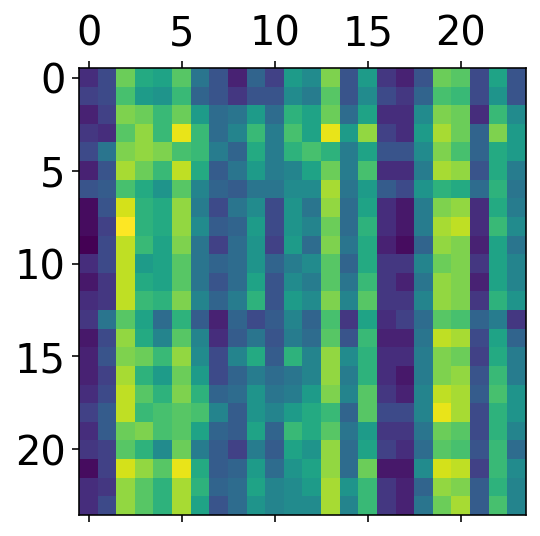

In [87]:
plt.matshow(pairwise_distances(df.values, means.values>0, metric="hamming"))